# Data Analysis - Random Forests

In [3]:
import pandas as pd
import numpy as np
import ast
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

In [4]:
def get_sorted_feat_importance(importance, feature_names):
    feature_importance = np.array(importance)
    feature_names = np.array(feature_names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df['cum_sum_fi']=fi_df['feature_importance'].cumsum()
    return fi_df

Get Data 

In [5]:
questions = pd.read_csv('D:/questions_prepared.csv', sep=';', index_col=0) # load data 
descriptive_questions = [i for i in questions.index if i.startswith('dq')] #find descriptive questions
# Apply ast.literal_eval to the 'Order' column for descriptive questions, handling NaN values
def safe_literal_eval(val):
    if pd.isna(val):
        return val
    return ast.literal_eval(val)
questions.loc[descriptive_questions, 'Order'] = questions.loc[descriptive_questions, 'Order'].apply(safe_literal_eval)

# Drop descriptive questions that relate to astrology/horoscope/superstition
descriptive_questions = [
    i for i in descriptive_questions
    if not any(keyword in questions.loc[i, 'text'] for keyword in ['horoscope', 'astrology', 'superstition'])
]

# Display the head of the questions DataFrame
display(questions.head())

,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
q_id,,,,,,,,,
q2,Breast implants?,more cool than pathetic,more pathetic than cool,NaN,NaN,24839,N,NaN,sex/intimacy; preference; opinion
q11,How does the idea of being slapped hard in the...,Horrified,Aroused,Nostalgic,Indifferent,28860,N,NaN,sex/intimacy
q12,Divide your age by 2. Have you had sex with a...,Yes,No,NaN,NaN,22496,O,NaN,sex/intimacy
q13,Is a girl who's slept with 100 guys a bad person?,Yes,No,NaN,NaN,32581,O,NaN,sex/intimacy
q14,Is a guy who's slept with 100 girls a bad person?,Yes,No,NaN,NaN,31127,O,NaN,sex/intimacy


# Training Data

In [6]:
data = pd.read_parquet('D:/train.parquet')
# per question count number of times the question is answered
n_answers_per_question = data.loc[:, descriptive_questions].count(axis=0)
sorted_questions = n_answers_per_question.sort_values(ascending=False).index

question_data = questions.join(n_answers_per_question.to_frame('n_answers')) 
display(questions.loc[sorted_questions[:10]][['text']])

features_df = data[descriptive_questions]
print('Nr of rows, nr of descriptive questions', features_df.shape)

,text
dq823,Do you like watching foreign movies with subti...
dq789,Which type of wine would you prefer to drink o...
dq34,Do you have any tattoos?
dq8,How frequently do you drink alcohol?
dq109,Have you smoked a cigarette in the last 6 months?
dq821,Do you enjoy intense intellectual conversations?
dq500,How much influence or control do your parents ...
dq516,Do you say 'Thank you' to wait staff when serv...
dq373,How often do you keep your promises?
dq420,How often are you open with your feelings?


Nr of rows, nr of descriptive questions (14993, 829)


In [7]:
# Get relative frequencies
freqs = data['Reading_horoscope'].value_counts(normalize=True)*100
title = questions.loc['q37764', 'text']
freqs

Reading_horoscope
Never.           47.202028
Occasionally.    47.101981
Daily.            3.421597
Weekly.           2.274395
Name: proportion, dtype: float64

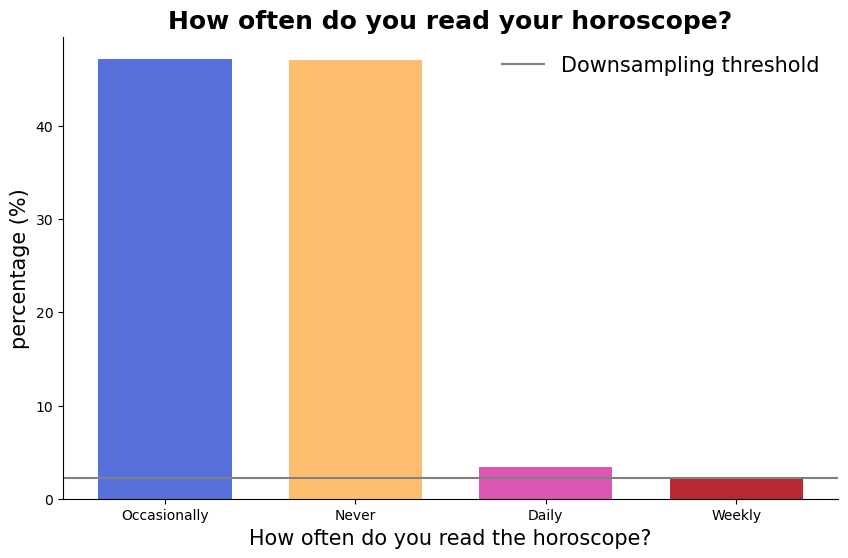

In [8]:
# Plot
plt.figure(figsize=(10, 6))
#plt.rcParams.update({'font.size': 15})
ax = plt.axes()
ax.set_facecolor('white')
plt.bar(freqs.index, 
            freqs.values,
            width=0.7,
            tick_label=['Occasionally', 'Never', 'Daily',  'Weekly',],
            color=['#5770db', '#fdbf6f', '#db57b2', '#ba2832', ])
plt.title(title, fontweight="bold", fontsize = 18)
plt.ylabel('percentage (%)', fontsize = 15)
plt.xlabel("How often do you read the horoscope?",fontsize = 15)
plt.tick_params(bottom=True, left=True)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_visible(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_color('black')
ax.axhline(y=2.274395, color='gray', linestyle='-', label='Downsampling threshold')
plt.legend(frameon=False,fontsize = 15)
plt.savefig("D:/Horoscope_ditribution.png")
plt.show()

In [9]:
df_trn, df_test = train_test_split(data[descriptive_questions + ['Reading_horoscope', 'gender', 'd_age']], test_size=0.1, random_state=1)
# split data into train and test set; subset includes all columns listed in descriptive_questions, as well as the Astrology, gender, and d_age columns.
df_test = df_test[descriptive_questions+['Reading_horoscope']] # not keeping gender and age for validation set 

# Random Forests

In [10]:
#Preparation - feature selection and variable encoding
#  Separate features and target
X_train = df_trn[descriptive_questions]
y_train = df_trn['Reading_horoscope']

X_test = df_test[descriptive_questions]
y_test = df_test['Reading_horoscope']

# Encode features and target
feature_encoder = OrdinalEncoder()
target_encoder = LabelEncoder()

X_train_encoded = feature_encoder.fit_transform(X_train)
y_train_encoded = target_encoder.fit_transform(y_train)

X_test_encoded = feature_encoder.transform(X_test)
y_test_encoded = target_encoder.transform(y_test)

# Select top k features using SelectKBest
k = 30
selector = SelectKBest(score_func=chi2, k=k)
X_train_selected = selector.fit_transform(X_train_encoded, y_train_encoded)
X_test_selected = selector.transform(X_test_encoded)



# Get the selected feature names
selected_features = [descriptive_questions[i] for i in selector.get_support(indices=True)]

# Train a Random Forest model with selected features
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_selected, y_train_encoded)



RandomForestClassifier(random_state=42)

# Evaluation Simple Model

Random Forest accuracy: 0.5707
Mean squared error: 0.5053333333333333


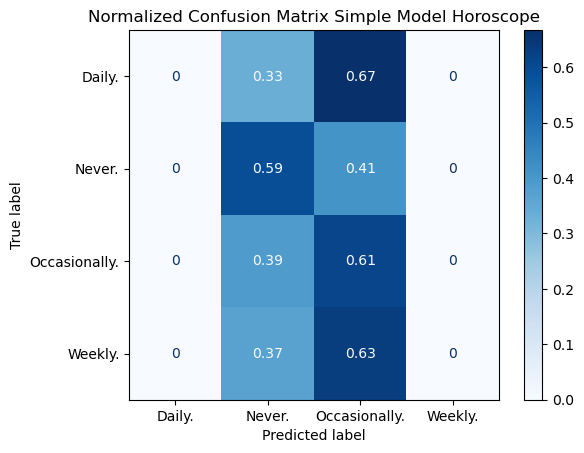

In [11]:
#Model accuracy
score = rf.score(X_test_selected, y_test_encoded)
print(f"Random Forest accuracy: {score:.4f}")


y_pred = rf.predict(X_test_selected)
# Mean squared error
mse = mean_squared_error(y_test_encoded, y_pred)
print("Mean squared error:", mse)

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_pred, normalize='true')

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix Simple Model Horoscope')
plt.savefig("D:/Confusion_Matrix_Horoscope_1.png")
plt.show()



# Downsampling and Hyperparameter Tuning 
to improve model accuracy 

In [12]:
# 'data' is your DataFrame and 'Astrology' is the target variable
target_column = 'Reading_horoscope'

# Calculate the number of samples for 2.274395% of the dataset
desired_fraction = 2.274395 / 100
total_samples = data.shape[0]
n_samples = int(total_samples * desired_fraction)

# Separate the dataset by class
classes = data[target_column].unique()
downsampled_classes = []

for cls in classes:
    class_subset = data[data[target_column] == cls]
    if class_subset.shape[0] > n_samples:
        downsampled_class = class_subset.sample(n=n_samples, random_state=42)
    else:
        downsampled_class = class_subset
    downsampled_classes.append(downsampled_class)

# Combine the downsampled classes into one DataFrame
downsampled_data = pd.concat(downsampled_classes).sample(frac=1, random_state=42).reset_index(drop=True)

# Print the distribution of classes in the downsampled dataset
print(downsampled_data[target_column].value_counts(normalize=True) * 100)

Reading_horoscope
Occasionally.    25.0
Daily.           25.0
Weekly.          25.0
Never.           25.0
Name: proportion, dtype: float64


In [13]:
df_trn_2, df_test_2 = train_test_split(downsampled_data[descriptive_questions + ['Reading_horoscope', 'gender', 'd_age']], test_size=0.1, random_state=1)
# split data into train and test set; subset includes all columns listed in descriptive_questions, as well as the Astrology, gender, and d_age columns.
df_test_2 = df_test_2[descriptive_questions+['Reading_horoscope']] # not keeping gender and age for validation set 

In [14]:
#Preparation - feature selection and variable encoding
#  Separate features and target
X_train_2 = df_trn_2[descriptive_questions]
y_train_2 = df_trn_2['Reading_horoscope']

X_test_2 = df_test_2[descriptive_questions]
y_test_2 = df_test_2['Reading_horoscope']

# Encode features and target
feature_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
target_encoder = LabelEncoder()

X_train_encoded_2 = feature_encoder.fit_transform(X_train_2)
y_train_encoded_2 = target_encoder.fit_transform(y_train_2)

X_test_encoded_2 = feature_encoder.transform(X_test_2)
y_test_encoded_2 = target_encoder.transform(y_test_2)

# Select top k features using SelectKBest
k = 30
selector_2 = SelectKBest(score_func=chi2, k=k)
X_train_selected_2 = selector_2.fit_transform(X_train_encoded_2, y_train_encoded_2)
X_test_selected_2 = selector_2.transform(X_test_encoded_2)



# Get the selected feature names
selected_features_2 = [descriptive_questions[i] for i in selector_2.get_support(indices=True)]




In [15]:
# Choose parameter distributions - Hyperparameter tuning 
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1500, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 15)]
min_samples_split = [8, 10, 12, 14, 15, 16, 18]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
              'bootstrap': bootstrap,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
pprint(param_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 17, 24, 31, 38, 45, 52, 60, 67, 74, 81, 88, 95, 102, 110],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [8, 10, 12, 14, 15, 16, 18],
 'n_estimators': [200, 344, 488, 633, 777, 922, 1066, 1211, 1355, 1500]}


In [16]:
# Train a Random Forest model with selected features
rf_2 = RandomForestClassifier(class_weight='balanced', random_state=1)
rf_random = RandomizedSearchCV(estimator = rf_2,
                             param_distributions = param_grid, 
                             n_iter = 10, 
                             cv = 3, 
                             verbose=2, 
                             random_state=42, 
                             n_jobs = -1, 
                             scoring='balanced_accuracy')
rf_random.fit(X_train_selected_2, y_train_encoded_2)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=1),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 17, 24, 31, 38, 45,
                                                      52, 60, 67, 74, 81, 88,
                                                      95, 102, 110],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [8, 10, 12, 14, 15,
                                                              16, 18],
                                        'n_estimators': [200, 344, 488, 633,
                                                         777, 922, 1066, 1211,
                                                         1355, 1500]},
                   random_state=42, scoring='balanced_accuracy', verbose=2)

In [17]:
print('Results of parameter tuning with cv random search:')
best_random_params = rf_random.best_params_
pprint(best_random_params)

Results of parameter tuning with cv random search:
{'bootstrap': True,
 'max_depth': 17,
 'min_samples_leaf': 3,
 'min_samples_split': 15,
 'n_estimators': 1066}


In [18]:
rf_tuned = rf_random.best_estimator_
scores = cross_val_score(rf_tuned, X_train_selected_2, y_train_encoded_2, cv=5, scoring='balanced_accuracy')
print(f"balanced accuracy with mean: {scores.mean()} a standard deviation of {scores.std()}")

balanced accuracy with mean: 0.3823858628591574 a standard deviation of 0.025785107693433534


Random Forest accuracy: 0.3577
Mean squared error: 2.1751824817518246


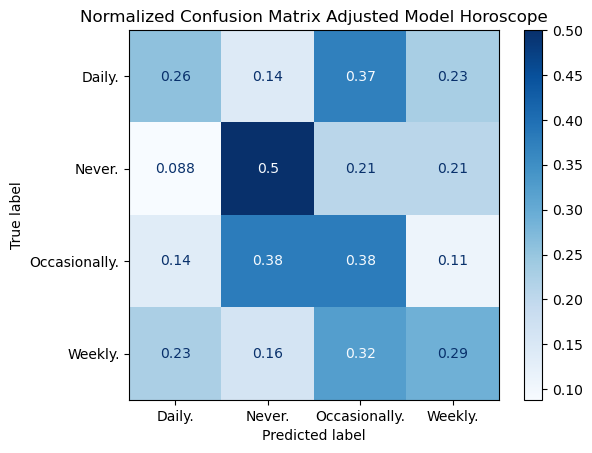

In [19]:
#Model accuracy
score_2 = rf_tuned.score(X_test_selected_2, y_test_encoded_2)
print(f"Random Forest accuracy: {score_2:.4f}")


y_pred_2 = rf_tuned.predict(X_test_selected_2)
# Mean squared error
mse_tuned = mean_squared_error(y_test_encoded_2, y_pred_2)
print("Mean squared error:", mse_tuned)

# Confusion Matrix
cm_tuned = confusion_matrix(y_test_encoded_2, y_pred_2, normalize='true')

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tuned, display_labels=target_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Normalized Confusion Matrix Adjusted Model Horoscope')
plt.savefig("D:/Confusion_Matrix_Horoscope_2.png")
plt.show()

# Feature Importance Adjusted Model

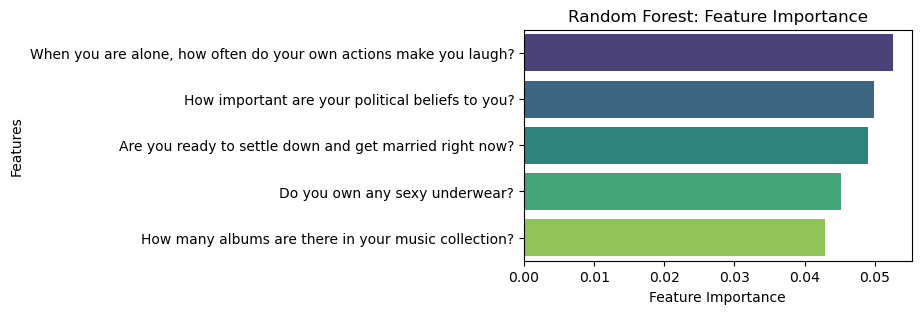

In [20]:
# Evaluate Feature Importance
feature_importances = rf_tuned.feature_importances_

feature_texts = [questions.loc[feature, 'text'] for feature in selected_features_2]

# Create a DataFrame for feature importances
fi_df = pd.DataFrame({'feature_names': feature_texts, 'feature_importance': feature_importances})
fi_df.sort_values(by='feature_importance', ascending=False, inplace=True)

# Select the top 5 features
top_5_fi_df = fi_df.head(5)

# Plot Feature Importance
plt.figure(figsize=(5, 3))
sns.barplot(y=top_5_fi_df['feature_names'], x=fi_df['feature_importance'], palette='viridis')
plt.title('Random Forest: Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.savefig("D:/Feature_Importance_Horoscope_2.png")
plt.show()

